### mecab 설치

In [43]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-10-24 01:40:51--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-10-24 01:40:52--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc22b498d6a27e6f96d4826533ff.dl.dropboxusercontent.com/cd/0/get/BvYPLKvl9OBnWoiOCi_-5jtGJSlBRtsZ7MiGgLKJ85XglSE2lMBJklymMNVEZr1Z3NR8dAFDZLtndtxLQpQYedfrSsaIOEWzLADevxgIVt9TrqXYy8FVAVDe1v3u5XMY-yI8ldfTWGx8tBd_RRwm_6zF3Lj48cnhNRiuLvcnNF47ki2emsvtN1bAIsfkpys4qgU/file?dl=1# [following]
--2022-10-24 01:40:52--  https://uc22b498d6a27e6f96d4826533ff.dl.dropboxusercontent.com/cd/0/get/BvYPLKvl9

In [44]:
from konlpy.tag import Okt
okt = Okt()
okt.morphs('하윙')

['하', '윙']

In [45]:
from konlpy.tag import Mecab
mecab = Mecab()
mecab.morphs('안녕하세용')

['안녕', '하세용']

### 데이터 불러오기 및 토큰화

In [46]:
with open('/content/drive/MyDrive/Colab Notebooks/LIFLOW/data/voice_phishing_stt/그놈목소리.txt', 'r', encoding = 'UTF8') as f :
  voice = f.readlines()
with open('/content/drive/MyDrive/Colab Notebooks/LIFLOW/data/voice_phishing_stt/수사기관사칭.txt', 'r', encoding = 'UTF8') as f :
  impersonation = f.readlines()
with open('/content/drive/MyDrive/Colab Notebooks/LIFLOW/data/voice_phishing_stt/은행사기.txt', 'r', encoding = 'UTF8') as f :
  fraud = f.readlines()

print(len(voice))
print(len(impersonation))
print(len(fraud))

35
157
96


In [47]:
voice = [v[:-1] for v in voice]
impersonation = [m[:-1] for m in impersonation]
fraud = [r[:-1] for r in fraud]

In [48]:
voice_noun = [mecab.nouns(v) for v in voice]
impersonation_noun = [mecab.nouns(p) for p in impersonation]
fraud_noun = [mecab.nouns(r) for r in fraud]
print(voice_noun[0])
print(impersonation_noun[0])
print(fraud_noun[0])

['방문', '금융', '어디', '구미', '중', '개', '형태', '형태', '돈', '진행', '중', '형태', '것', '상품', '겁니다', '전화', '건', '오해', '전화', '원인', '본인', '통장', '제도', '김종호', '주범', '불법', '금전', '거래', '통장', '고의', '양도', '건지', '개인', '정보', '유출', '사용', '금융', '이메일', '번호', '저녁']
['김장환', '은행', '금융', '직원', '은행', '가정', '이거', '자금', '느낌', '증거물', '수', '거기', '말씀']
['저희', '금융', '저축', '은행', '월', '달', '저희', '플러스', '채널', '오', '십', '자금', '대출', '상품', '대', '진행', '부분', '창원', '길거리', '오뎅', '중', '도상환', '수수료', '발생', '원리금', '균등', '분할', '상환', '만기', '일시', '상환', '쪽', '부분', '천만', '원', '천만', '원', '거', '고객', '사용', '휴대폰', '본인', '이름', '거', '삼성', '스마트폰', '카톡', '여기', '카톡', '추가', '저희', '상의', '제', '이름', '저', '전화', '통화', '중', '전화', '카톡', '연락', '수', '거']


### keyBERT로 키워드 더 뽑아보기

In [49]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

In [51]:
voice_doc = ' '.join(voice)
impersonation_doc = ' '.join(impersonation)
fraud_doc = ' '.join(fraud)

In [52]:
voice_noun_join = ''
impersonation_noun_join = ''
fraud_noun_join = ''

for i in voice_noun :
  voice_noun_join += ' '.join(i)

for i in impersonation_noun :
  impersonation_noun_join += ' '.join(i)

for i in fraud_noun :
  fraud_noun_join += ' '.join(i)

In [53]:
count1 = CountVectorizer().fit([voice_noun_join])
candidates1 = count1.get_feature_names_out()

count2 = CountVectorizer().fit([impersonation_noun_join])
candidates2 = count2.get_feature_names_out()

count3 = CountVectorizer().fit([fraud_noun_join])
candidates3 = count3.get_feature_names_out()


In [54]:
print(candidates1[:3])
print(candidates2[:3])
print(candidates3[:3])

['가격' '가능' '가수']
['가게' '가격' '가결']
['가나' '가능' '가능언니']


In [55]:
"""
tokenizer = Tokenizer()
tokenizer.fit_on_texts(voice_noun_join)
"""

'\ntokenizer = Tokenizer()\ntokenizer.fit_on_texts(voice_noun_join)\n'

In [56]:
#tokenizer.word_counts

In [57]:
"""
tokenizer1 = Tokenizer()
tokenizer2 = Tokenizer()
tokenizer3 = Tokenizer()
tokenizer1.fit_on_texts(voice_noun_join)
tokenizer2.fit_on_texts(impersonation_noun_join)
tokenizer3.fit_on_texts(fraud_noun_join)
voice_count_desc = sorted(tokenizer1.word_counts, key = lambda x : x[1], reverse = True)
impersonation_count_desc = sorted(tokenizer2.word_counts, key = lambda x : x[1], reverse = True)
fraud_count_desc = sorted(tokenizer3.word_counts, key = lambda x : x[1], reverse = True)
"""

'\ntokenizer1 = Tokenizer()\ntokenizer2 = Tokenizer()\ntokenizer3 = Tokenizer()\ntokenizer1.fit_on_texts(voice_noun_join)\ntokenizer2.fit_on_texts(impersonation_noun_join)\ntokenizer3.fit_on_texts(fraud_noun_join)\nvoice_count_desc = sorted(tokenizer1.word_counts, key = lambda x : x[1], reverse = True)\nimpersonation_count_desc = sorted(tokenizer2.word_counts, key = lambda x : x[1], reverse = True)\nfraud_count_desc = sorted(tokenizer3.word_counts, key = lambda x : x[1], reverse = True)\n'

#### voice

In [58]:
model1 = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
doc_embedding1 = model1.encode([voice_doc])
candidate_embeddings1 = model1.encode(candidates1)

In [59]:
top_n = 30
distances1 = cosine_similarity(doc_embedding1, candidate_embeddings1)
keywords1 = [candidates1[index] for index in distances1.argsort()[0][-top_n:]]
print(keywords1)

['고가', '설득', '구매', '출근', '방해죄', '대리점', '해킹', '불량품', '물건통화', '신청자', '재판부', '판매', '고소', '상인', '재판', '수수료', '사기', '상품권', '검찰', '체포영장', '신분증개설', '도난', '검찰청', '판매처', '집행', '압수수색', '재벌', '판매자', '쇼핑', '고객']


In [60]:
def max_sum_sim(doc_embedding, candidate_embeddings, words, top_n, nr_candidates):
    # 문서와 각 키워드들 간의 유사도
    distances = cosine_similarity(doc_embedding, candidate_embeddings)

    # 각 키워드들 간의 유사도
    distances_candidates = cosine_similarity(candidate_embeddings, 
                                            candidate_embeddings)

    # 코사인 유사도에 기반하여 키워드들 중 상위 top_n개의 단어를 pick.
    words_idx = list(distances.argsort()[0][-nr_candidates:])
    words_vals = [words[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]

    # 각 키워드들 중에서 가장 덜 유사한 키워드들간의 조합을 계산
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [words_vals[idx] for idx in candidate]

In [61]:
def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):

    # 문서와 각 키워드들 간의 유사도가 적혀있는 리스트
    word_doc_similarity = cosine_similarity(candidate_embeddings, doc_embedding)

    # 각 키워드들 간의 유사도
    word_similarity = cosine_similarity(candidate_embeddings)

    # 문서와 가장 높은 유사도를 가진 키워드의 인덱스를 추출.
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # keywords_idx = [2]
    keywords_idx = [np.argmax(word_doc_similarity)]

    # 가장 높은 유사도를 가진 키워드의 인덱스를 제외한 문서의 인덱스들
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # ==> candidates_idx = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10 ... 중략 ...]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    # 최고의 키워드는 이미 추출했으므로 top_n-1번만큼 아래를 반복.
    # ex) top_n = 5라면, 아래의 loop는 4번 반복됨.
    for _ in range(top_n - 1):
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # MMR을 계산
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # keywords & candidates를 업데이트
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [62]:
max_sum_sim(doc_embedding1, candidate_embeddings1, candidates1, top_n=5, nr_candidates=10)

['신분증개설', '도난', '재벌', '쇼핑', '고객']

In [63]:
mmr(doc_embedding1, candidate_embeddings1, candidates1, top_n=5, diversity=0.2)

['고객', '재벌', '쇼핑', '판매자', '신분증개설']

#### impersonation

In [64]:
model2 = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
doc_embedding2 = model2.encode([impersonation_doc])
candidate_embeddings2 = model2.encode(candidates2)

In [65]:
top_n = 30
distances2 = cosine_similarity(doc_embedding2, candidate_embeddings2)
keywords2 = [candidates2[index] for index in distances2.argsort()[0][-top_n:]]
print(keywords2)

['증거품', '변호사', '연예인', '피의자', '심사', '부탁예전', '활용', '거래법', '번호수고', '개설', '공부수고', '보안', '직거래', '유선주', '문제집', '텐데요', '가해자군', '영업', '집행', '심문', '금시초문', '경찰청서울', '재판', '판매자', '사건전화', '검찰', '검찰청', '미용실', '구매자', '고객']


In [66]:
max_sum_sim(doc_embedding2, candidate_embeddings2, candidates2, top_n=5, nr_candidates=10)

['경찰청서울', '재판', '판매자', '미용실', '고객']

In [67]:
mmr(doc_embedding2, candidate_embeddings2, candidates2, top_n=5, diversity=0.2)

['고객', '미용실', '검찰청', '보안', '거래법']

#### fraud

In [68]:
model3 = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')
doc_embedding3 = model3.encode([fraud_doc])
candidate_embeddings3 = model3.encode(candidates3)

In [69]:
top_n = 30
distances3 = cosine_similarity(doc_embedding3, candidate_embeddings3)
keywords3 = [candidates3[index] for index in distances3.argsort()[0][-top_n:]]
print(keywords3)

['오락', '합법', '평택', '수수료', '신용', '이정훈', '출자금', '자고객', '시작통화', '신용도', '매출', '감이', '이성현', '홍보', '거고객', '영업', '텐데요', '수고객', '주세고객', '나고객', '고객', '이재성', '공모', '고객제', '고객일', '고객말씀', '활용', '영업부', '입금고객', '고객저희']


In [70]:
max_sum_sim(doc_embedding3, candidate_embeddings3, candidates3, top_n=5, nr_candidates=10)

['이재성', '공모', '고객제', '활용', '고객저희']

In [71]:
mmr(doc_embedding3, candidate_embeddings3, candidates3, top_n=5, diversity=0.2)

['고객저희', '필요황혜진', '활용', '영업부', '입금고객']

### 모델링시작

In [72]:
keywords = list(set(['대포통장', '명의도용', '개인정보유출', '금융범죄', '수사관', '동결', '서울중앙지검', '신용카드', '피해자', '녹취',
            '방해죄', '해킹', '재판부', '고소', '재판', '수수료', '사기', '검찰', '체포영장', '신분증개설', '도난', '검찰청', '집행', '압수수색',
            '변호사', '피의자', '거래법', '개설', '보안', '영업', '경찰청', '검찰', 
            '수수료', '신용', '신용도', '입금']))

In [73]:
#from gensim.models import FastText
#result = voice_noun + impersonation_noun + fraud_noun
#model = FastText(result, size=100, window=5, min_count=5, workers=4, sg=1)

In [74]:
#model.most_similar('대포통장')

In [75]:
import random
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LIFLOW/data/all_df_with_tokens_according_to_topic.csv')
df.head()

,Unnamed: 0,sentence,tokens,cityCode,convrsThema,gender,age
0,0,밥 한끼를 제대로 된 밥 한끼를 먹을 수 있다고 생각하면서 감사하게 감사하게 생각하...,밥 끼 제대로 밥 끼 수 생각 생각 노후 제 가장 연예인 별 온 그대 전지현 잔디 ...,경상,방송/연예,여,60
1,1,그거 먹고 살아야 되는 거지 자식 물려줄 필요없고요 그걸로 모자라는 부분은 다른 곳...,그거 거지 자식 걸 부분 다른 곳 충당 백세 시대 요즘 자식 부모 자기 자기 자식 ...,경상,경제/재태크,여,60
2,2,결국 주차 요금을 올릴 수밖에 없어요 결국 최씨는 수리를 삼십일로 미뤄야 했습니다 ...,주차 요금 수 최씨 수리 삼십일 최종 결론 연말 퇴진 시점 알 수가 필자 인상 편이...,경상,PBS,여,60
3,3,저 사람이 나한테 저렇게 행동을 하는구나 저 사람이 원하는 게 무엇인가를 내가 생각...,저 사람 나 행동 저 사람 게 무엇 를 내 생각 사람 일이 생각 극 달 화가 내 좀...,기타,휴일,여,60
4,4,이 사람의 입장은 이럴 수 있구나 라고 배울 수 있는거지 그런건 정말 중요하고 꼭 ...,이 사람 입장 수 수 정말 꼭 것 친구 옛날 사람 손 맛 우리 쪽 다슬기 거 전혀 ...,기타,먹거리,여,60


In [76]:
voice_phishing_txt = random.sample(voice+impersonation+fraud, 10)
normal_txt = random.sample(list(df['sentence']), 10)
print(voice_phishing_txt)
print(normal_txt)

['여보세요 자기 통화 가능 하신 거예요 먼저 말씀 드리겠습니다 아닙니다 아니라고요 거짓말 하신 거 같은데 자책으로 하겠습니다 사건 내용 확인하시고요 지점으로 재방 있어요 아시겠죠 본인이 안 보냅니다', '전화 해야 되겠죠 아네 잠시만요 주민 번호 앞자리 확인 부탁드리겠습니다 혹시 팀장님 나오는데 연결해 드릴까요네 잠시만요네 감사합니다 잠시만요 잠시만요 안녕하세요 일단 이거는 일단 있으시면 그 부분을 프로에서 10% 큰집에서 갈아타시는 상품이세요 만나서 농협캐피탈 확인 안 되세요 그리고이 번호는 저희 그거 심사부 한번 오세요 인사 드릴 때 인사 먼저 드렸었는데', '잘 안 들리세요 1월 11일 날짜로 해서 대출신청서 하나만 더 작성 좀 해 주셔야 될 것 같은데요 카카오톡으로 지금 전화 통화하면서 저랑 같이 대출 신청 부탁 좀 드릴게요 그럼 전화로 찾는다고', '어디라고요 확인이 되어 이렇게 1차적으로 되었습니다 통장에 2 통장에 돈이 되는 상황입니다 40세 통장이 2014년 8월 7일 통장을 통장을 오늘 일찍 하셨나요', '제가 지금 몇 가지만 그럼 질문드리고 사건 번호 말씀 드릴게요 혹시 수원시 팔달구 거주하던 40대 남성입니다 김태환 맛있는 거 있으니까 저녁 모르세요 작은 최근 1년 사이에 본인 개인 정보가 담긴 물품을 하시거나 고난당하신 적 있으십니까 따로 없으시고요 SNS 나 이메일 좀 자주 이용하시는 편이세요 이용하시면서 해킹당할 신정은 없으시고요 따로 일단 이러한 상황이기 때문에 제가 지금부터 본인께서 사용하시는 금융권 상호와 용도에 대해서만 좀 진주를 받을 건데 다시 한번 말씀드리지만 본인 계좌 번호나 비밀번호 이런 개인정보에 관한 건 절대 말씀하시면 안 되시고요 앞서서 저희 쪽에 진술 하지 않는 내용이 한해서 본인의 추가적인 통장이 발견했을 땐 저희 쪽에서 이제 대포통장으로 간주가 되고 동결처리 가지는 될 수 있다는 점 인제 해 주시고요 작은 첫 번째로 보낼 때도 사용하시는 금융권 사고에 대해서 말씀 진실을 받을 건데 어렸을 때 만드시고 사용을 

In [77]:
voice_phishing_txt_token = [mecab.nouns(w) for w in voice_phishing_txt]
normal_txt_token = [mecab.nouns(w) for w in normal_txt]
print(voice_phishing_txt_token[:2])
print(normal_txt_token[:2])

[['자기', '통화', '가능', '거', '말씀', '거짓말', '거', '자책', '사건', '내용', '확인', '지점', '재방', '본인'], ['전화', '만요', '주민', '번호', '앞자리', '확인', '부탁', '팀장', '연결', '만요', '감사', '만요', '잠시', '이거', '부분', '프로', '집', '상품', '농협', '캐피탈', '확인', '번호', '저희', '그거', '심사', '부', '번', '인사', '때', '인사']]
[['건', '무릎', '부담', '숫자', '번', '시업', '쇼파', '티브이', '집', '아령', '저', '집', '팔', '층', '때', '엘리베이터', '시간', '내', '건', '일', '주일', '번', '차밍', '댄스', '운동', '나머지', '계단', '우리', '막둥이', '아침', '저녁', '운동', '일상', '운동', '시간', '수', '이것', '우리', '아침', '푸', '시업', '시업', '자기', '건강', '자기', '우리', '남편', '나이', '말', '애', '것', '연세', '등', '분', '부부', '아침', '운동', '그분', '강아지', '대화', '제', '순둥이', '얘기', '혼자'], ['둘', '나이', '살', '차이', '이게', '때', '그걸', '밑', '발', '거', '그걸', '집', '이게', '거기']]


In [78]:
#model.most_similar('저번')
#OOV 문제 발생. pretrained로 해야할듯

In [79]:
!pip install --upgrade gensim==3.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from gensim import models

ko_model = models.fasttext.load_facebook_model('/content/drive/MyDrive/Colab Notebooks/FastText_pretrained/cc.ko.300.bin')

ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa1\x9c'; replacing invalid characters, using '\\xed\\xa1\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb0\x80'; replacing invalid characters, using '\\xed\\xb0\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa7\x80'; replacing invalid characters, using '\\xed\\xa7\\x80'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb8\xb0'; replacing invalid characters, using '\\xed\\xb8\\xb0'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa0\x9c'; replacing invalid characters, using '\\xed\\xa0\\x9c'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xa6\xac'; replacing invalid characters, using '\\xed\\xa6\\xac'
ERROR:gensim.models._fasttext_bin:failed to decode invalid unicode bytes b'\xed\xb3\xb5'; replacing invalid characters, using '\\xed\\xb

In [ ]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

#### vanila하게 결과보기

In [ ]:
def detection_vanila(target, keywords, model, window_size=5) :
  target_sim = []
  keywords_vect = []
  for i in range(len(keywords)) :
    keywords_vect.append(model[keywords[i]])

  for i in range(len(target)) :
    tmp_sum = 0
    for j in range(len(keywords_vect)) :
      tmp_sum += cos_sim(model[target[i]], keywords_vect[j])
    target_sim.append(tmp_sum)
  return target_sim, sum(target_sim) / len(target_sim)


In [41]:
mean_voice_phishing = []
mean_normal = []

for i in range(len(normal_txt_token)) :
  mean_normal.append(detection_vanila(normal_txt_token[i], keywords, ko_model)[1])

for i in range(len(voice_phishing_txt_token)) :
  mean_voice_phishing.append(detection_vanila(voice_phishing_txt_token[i], keywords, ko_model)[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in float_scalars
  """


In [42]:
print(mean_normal)
print(mean_voice_phishing)

[3.997686469984496, 4.285552737961755, 3.772477957858549, 3.4330568589422104, 3.8806444467869974, 3.9857384661180815, 3.9143920972943307, 3.8670667694536056, 4.330788102311392, 3.857740893252678]
[5.219109069699438, 5.071173944414278, 4.694254377148388, 5.559870718441541, 5.914664463552001, 4.742429119571293, 4.470349463251578, 4.90362695978461, nan, 4.901668278930513]


#### window 설정해서 보기

In [84]:
def detection_window(target, keywords, model, window_size=5) :
  target_sim = []
  keywords_vect = []
  for i in range(len(keywords)) :
    keywords_vect.append(model[keywords[i]])

  for i in range(len(target)) :
    tmp_sum = 0
    for j in range(len(keywords_vect)) :
      tmp_sum += cos_sim(model[target[i]], keywords_vect[j])
    target_sim.append(tmp_sum)
  
  result = []
  for i in range(len(target_sim) - window_size + 1) :
    w_sim = target_sim[i:i+window_size]
    w_avg = sum(w_sim) / window_size
    result.append(w_avg)
  return result

In [85]:
window_voice_phishing = []
window_normal = []

for i in range(len(normal_txt_token)) :
  window_normal.append(detection_window(normal_txt_token[i], keywords, ko_model))

for i in range(len(voice_phishing_txt_token)) :
  window_voice_phishing.append(detection_window(voice_phishing_txt_token[i], keywords, ko_model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [86]:
print(window_voice_phishing)
print(window_normal)

[[4.871935673314146, 4.995738997939043, 4.685486962995492, 4.395906637283042, 4.924064528150484, 5.247504778299481, 5.5481257599778475, 5.704707413166761, 5.885543756722472, 5.565271818800829], [4.9230895895510915, 4.716135986149311, 5.090736146504059, 5.313757453346625, 5.1393505888525395, 5.014370250562206, 4.98214834802784, 4.607548187673092, 3.760449162480654, 3.6989048372779507, 3.8344229450274723, 3.5884409466583747, 4.088431532849791, 4.846521460078657, 5.341758280061185, 5.283912931475788, 5.562116832379251, 5.648519845400005, 5.444651262275874, 4.994803408579901, 5.605984510062262, 5.315378081565723, 4.690681307064369, 4.830826368508861, 4.357858429953922, 4.204778087243904], [5.609380646422506, 5.1343103558872825, 5.2995327395270575, 4.910716307244729, 4.354711176536512, 4.796562122635078, 5.554960839799605, 5.416694918973372, 6.2568176932167265, 6.546777835069224, 6.132411634735763, 6.222385008446873], [5.719954392034561, 5.929498183366377, 5.795384239417035, 5.3937580959755

#### plot 그리기

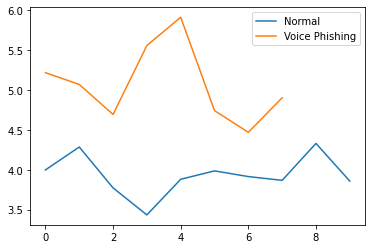

In [90]:
import matplotlib.pyplot as plt

plt.plot(mean_normal)
plt.plot(mean_voice_phishing)
plt.legend(['Normal', 'Voice Phishing'])

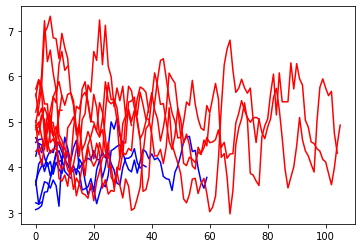

In [94]:
plt.plot(window_normal[0], 'b-')
plt.plot(window_normal[1], 'b-')
plt.plot(window_normal[2], 'b-')
plt.plot(window_normal[3], 'b-')
plt.plot(window_normal[4], 'b-')
plt.plot(window_normal[5], 'b-')
plt.plot(window_normal[6], 'b-')
plt.plot(window_normal[7], 'b-')
plt.plot(window_normal[8], 'b-')
plt.plot(window_normal[9], 'b-')

plt.plot(window_voice_phishing[0], 'r-')
plt.plot(window_voice_phishing[1], 'r-')
plt.plot(window_voice_phishing[2], 'r-')
plt.plot(window_voice_phishing[3], 'r-')
plt.plot(window_voice_phishing[4], 'r-')
plt.plot(window_voice_phishing[5], 'r-')
plt.plot(window_voice_phishing[6], 'r-')
plt.plot(window_voice_phishing[7], 'r-')
plt.plot(window_voice_phishing[8], 'r-')
plt.plot(window_voice_phishing[9], 'r-')

#plt.legend(['Normal', 'Voice Phishing'])